In [1]:
import numpy as np
from scipy.misc import imresize
import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform, filters
import sys, pylab, operator, csv
#import util
import os
import urllib

%matplotlib notebook

%load_ext autoreload
%autoreload 2

import caffe

from helpers import *
from heatmaps import *
from repro_EB_figs import *
from optimize_mask import *

In [2]:
gpu = 0
net_type = 'googlenet'

In [3]:
caffe.set_device(gpu)
caffe.set_mode_gpu()

net = get_net(net_type)

# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_spl

In [4]:
labels_desc = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_words.txt', str, delimiter='\t')
synsets = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t')
(paths, labels) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/annotated_train_heldout_imdb.txt')
data_desc = 'train_heldout'
paths = np.array(paths)
labels = np.array(labels)
ann_dir = '/data/ruthfong/ILSVRC2012/annotated_train_heldout_ground_truth_annotations'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])
res_dir = '/data/ruthfong/neural_coding/pycaffe_results'
#mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
mask_paths = [os.path.join(res_dir, mask_rel_dir, '%d.npy' % x) for x in range(len(labels))]

In [21]:
mean_heatmap = []
for i in range(len(labels)):
    heatmap = np.load(mask_paths[i])
    mean_heatmap.append(heatmap.mean())
mean_heatmap = np.array(mean_heatmap)

print '%f, %f' % (mean_heatmap.mean(), mean_heatmap.std())

mean_heatmap_masks = np.copy(mean_heatmap)

0.779081, 0.128166


0.000232, 0.000086


<IPython.core.display.Javascript object>


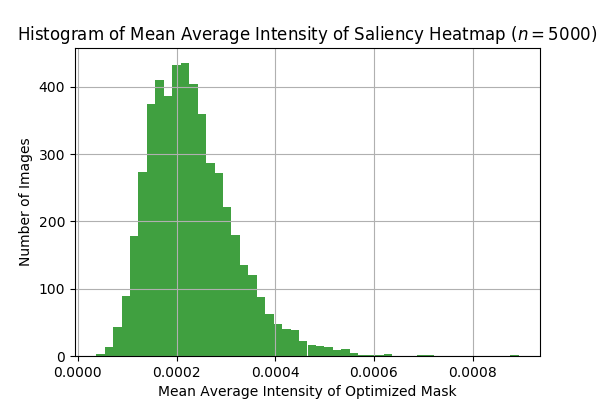

In [7]:
mean_heatmap = []
max_heatmap = []
min_heatmap = []
heatmap_type = 'saliency'
top_name = 'loss3/classifier'

net_transformer = get_ILSVRC_net_transformer(net)
for i in range(len(labels)):
    heatmap = compute_heatmap(net, net_transformer, paths[i], labels[i], heatmap_type, top_name, top_name,
                    outputBlobName = 'data', outputLayerName = 'data', norm_deg = np.inf, gpu = gpu)
    mean_heatmap.append(heatmap.mean())
    max_heatmap.append(heatmap.max())
    min_heatmap.append(heatmap.min())

mean_heatmap = np.array(mean_heatmap)
max_heatmap = np.array(max_heatmap)
min_heatmap = np.array(min_heatmap)
print 'mean: %f, %f' % (mean_heatmap.mean(), mean_heatmap.std())
print 'max: %f, %f' % (max_heatmap.mean(), max_heatmap.std())
print 'min: %f, %f' % (min_heatmap.mean(), min_heatmap.std())

mean_heatmap_sal = np.copy(mean_heatmap)

pylab.rcParams['figure.figsize'] = (6.0, 4.0)
f, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(mean_heatmap, 50, facecolor='green', alpha=0.75)

ax.set_xlabel('Mean Average Intensity of Optimized Mask')
ax.set_ylabel('Number of Images')
ax.set_title(r'Histogram of Mean Average Intensity of Saliency Heatmap $(n = 5000)$')
plt.grid(True)

In [25]:
mean_heatmap = []
heatmap_type = 'guided_backprop'
top_name = 'loss3/classifier'

net_transformer = get_ILSVRC_net_transformer(net)
for i in range(len(labels)):
    heatmap = compute_heatmap(net, net_transformer, paths[i], labels[i], heatmap_type, top_name, top_name,
                    outputBlobName = 'data', outputLayerName = 'data', norm_deg = np.inf, gpu = gpu)
    mean_heatmap.append(heatmap.mean())
mean_heatmap = np.array(mean_heatmap)

print '%f, %f' % (mean_heatmap.mean(), mean_heatmap.std())

mean_heatmap_guided = np.copy(mean_heatmap)

0.000442, 0.000175


In [5]:
mean_heatmap = []
heatmap_type = 'excitation_backprop'
top_name = 'loss3/classifier'
bottom_name = 'pool2/3x3_s2'
norm_deg = -1
net_transformer = get_ILSVRC_net_transformer(net)
for i in range(len(labels)):
    heatmap = compute_heatmap(net, net_transformer, paths[i], labels[i], heatmap_type, top_name, top_name,
                    outputBlobName = bottom_name, outputLayerName = bottom_name, norm_deg = norm_deg, gpu = gpu)
    mean_heatmap.append(heatmap.mean())
mean_heatmap = np.array(mean_heatmap)

print '%f, %f' % (mean_heatmap.mean(), mean_heatmap.std())

mean_heatmap_excitation = np.copy(mean_heatmap)

0.001276, 0.000000


<IPython.core.display.Javascript object>


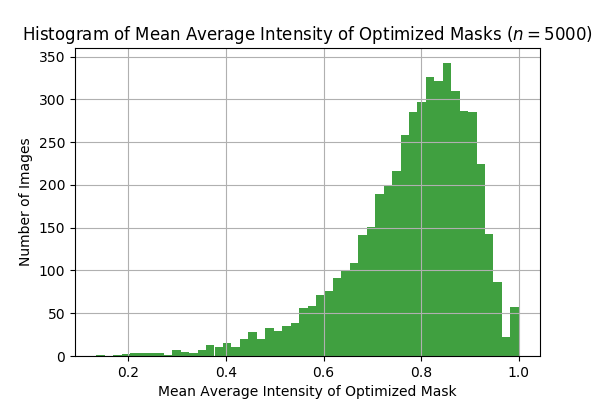

In [20]:
pylab.rcParams['figure.figsize'] = (6.0, 4.0)
f, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(mean_heatmap, 50, facecolor='green', alpha=0.75)

ax.set_xlabel('Mean Average Intensity of Optimized Mask')
ax.set_ylabel('Number of Images')
ax.set_title(r'Histogram of Mean Average Intensity of Optimized Masks $(n = 5000)$')
plt.grid(True)


# Alpha-Energy

## Finding Best Alpha

In [6]:
def getbb_from_heatmap_2(heatmap, alpha, method = 'mean', resize = None, thres_first = True):
    if not thres_first and resize is not None:
        heatmap = imresize(heatmap, resize)

    assert(method == 'mean' or method == 'min_max_diff' or method == 'energy')

    if method == 'mean':
        threshold = alpha*heatmap.mean()
        heatmap[heatmap < threshold] = 0
    elif method == 'min_max_diff':
        threshold = alpha*(heatmap.max()-heatmap.min())
        heatmap_m = heatmap - heatmap.min()
        heatmap[heatmap_m < threshold] = 0
    elif method == 'energy':
        heatmap_f = heatmap.flatten()
        sorted_idx = np.argsort(heatmap_f)[::-1]
        #heatmap_s = np.sort(heatmap_f)[::-1]
        tot_energy = heatmap.sum()
        heatmap_cum = np.cumsum(heatmap_f[sorted_idx])
        ind = np.where(heatmap_cum >= alpha*tot_energy)[0][0]
        heatmap_f[sorted_idx[ind:]] = 0
        heatmap = np.reshape(heatmap_f, heatmap.shape)

    if thres_first and resize is not None:
        heatmap = imresize(heatmap, resize)

    if (heatmap == 0).all():
        if resize is not None:
            return [1,1,resize[0],resize[1]]
        else:
            return [1,1,heatmap.shape[0],heatmap.shape[1]]

    x = np.where(heatmap.sum(0) > 0)[0] + 1
    y = np.where(heatmap.sum(1) > 0)[0] + 1
    return ([x[0],y[0],x[-1],y[-1]], heatmap)

141 1 500 272


<IPython.core.display.Javascript object>


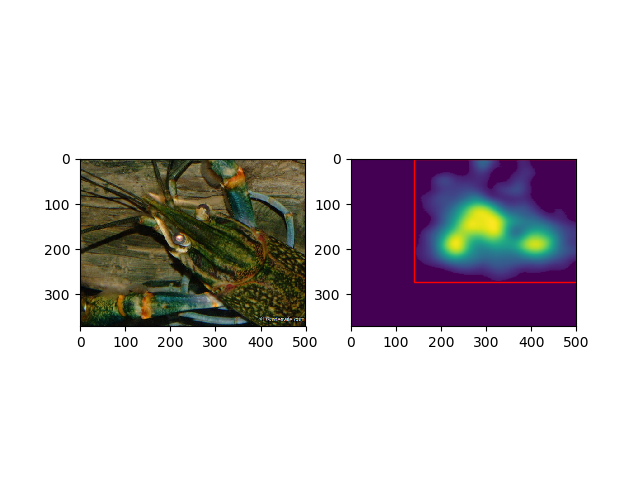

In [29]:
img = caffe.io.load_image(paths[2])
heatmap = 1-np.load(mask_paths[2])
alpha = 0.95
([x0,y0,x1,y1], heatmap_t) = getbb_from_heatmap_2(heatmap, alpha, method = 'energy', resize = img.shape[:2], thres_first = True)
print x0,y0,x1,y1
f,ax = plt.subplots(1,2)
ax[0].imshow(img)
#ax[1].imshow(imresize(heatmap, img.shape[:2]))
ax[1].imshow(heatmap_t)
ax[1].add_patch(patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=1,edgecolor='r',facecolor='none'))

In [8]:
def find_best_alpha(bb_file_prefix, alphas = np.arange(0,1,0.05)):
    errs = np.zeros(len(alphas))
    for i in range(len(alphas)):
        alpha = alphas[i]
        bb_file = bb_file_prefix % alpha
        (err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                                     reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
        errs[i] = err
    for i in range(len(alphas)):
        print 'alpha = %.2f, err = %f' % (alphas[i], errs[i])
    min_i = np.argmin(errs)
    print 'best alpha = %.2f, err = %f' % (alphas[min_i], errs[min_i])
    return errs

In [35]:
print 'Mask'
find_best_alpha('/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/energy_alpha_%.2f_norm_Inf.txt')

Mask
1050 5000.0
437 5000.0
691 5000.0
888 5000.0
1073 5000.0
1250 5000.0
1388 5000.0
1531 5000.0
1645 5000.0
1809 5000.0
1946 5000.0
2066 5000.0
2206 5000.0
2356 5000.0
2526 5000.0
2648 5000.0
2787 5000.0
2914 5000.0
3020 5000.0
3044 5000.0
alpha = 0.00, err = 0.790000
alpha = 0.05, err = 0.912600
alpha = 0.10, err = 0.861800
alpha = 0.15, err = 0.822400
alpha = 0.20, err = 0.785400
alpha = 0.25, err = 0.750000
alpha = 0.30, err = 0.722400
alpha = 0.35, err = 0.693800
alpha = 0.40, err = 0.671000
alpha = 0.45, err = 0.638200
alpha = 0.50, err = 0.610800
alpha = 0.55, err = 0.586800
alpha = 0.60, err = 0.558800
alpha = 0.65, err = 0.528800
alpha = 0.70, err = 0.494800
alpha = 0.75, err = 0.470400
alpha = 0.80, err = 0.442600
alpha = 0.85, err = 0.417200
alpha = 0.90, err = 0.396000
alpha = 0.95, err = 0.391200
best alpha = 0.95, err = 0.391200


array([ 0.79  ,  0.9126,  0.8618,  0.8224,  0.7854,  0.75  ,  0.7224,
        0.6938,  0.671 ,  0.6382,  0.6108,  0.5868,  0.5588,  0.5288,
        0.4948,  0.4704,  0.4426,  0.4172,  0.396 ,  0.3912])

In [9]:
print 'Saliency'
_ = find_best_alpha('/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/saliency/energy_alpha_%.2f_norm_Inf.txt')

Saliency
alpha = 0.00, err = 0.790000
alpha = 0.05, err = 0.458000
alpha = 0.10, err = 0.402600
alpha = 0.15, err = 0.405600
alpha = 0.20, err = 0.419200
alpha = 0.25, err = 0.438200
alpha = 0.30, err = 0.452000
alpha = 0.35, err = 0.465600
alpha = 0.40, err = 0.479000
alpha = 0.45, err = 0.495200
alpha = 0.50, err = 0.507200
alpha = 0.55, err = 0.518600
alpha = 0.60, err = 0.526600
alpha = 0.65, err = 0.533600
alpha = 0.70, err = 0.539800
alpha = 0.75, err = 0.544800
alpha = 0.80, err = 0.548000
alpha = 0.85, err = 0.551600
alpha = 0.90, err = 0.553600
alpha = 0.95, err = 0.555600
best alpha = 0.10, err = 0.402600


In [10]:
print 'Guided Backprop'
_ = find_best_alpha('/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/guided_backprop/energy_alpha_%.2f_norm_Inf.txt')

Guided Backprop
alpha = 0.00, err = 0.790000
alpha = 0.05, err = 0.575400
alpha = 0.10, err = 0.499200
alpha = 0.15, err = 0.456800
alpha = 0.20, err = 0.441400
alpha = 0.25, err = 0.432600
alpha = 0.30, err = 0.421600
alpha = 0.35, err = 0.426600
alpha = 0.40, err = 0.429200
alpha = 0.45, err = 0.431600
alpha = 0.50, err = 0.439400
alpha = 0.55, err = 0.449400
alpha = 0.60, err = 0.464800
alpha = 0.65, err = 0.479600
alpha = 0.70, err = 0.496400
alpha = 0.75, err = 0.511400
alpha = 0.80, err = 0.524600
alpha = 0.85, err = 0.536800
alpha = 0.90, err = 0.545400
alpha = 0.95, err = 0.553000
best alpha = 0.30, err = 0.421600


In [15]:
print 'Excitation Backprop'
_ = find_best_alpha('/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/excitation_backprop/energy_alpha_%.2f_norm_-1.txt')

Excitation Backprop
alpha = 0.00, err = 0.790000
alpha = 0.05, err = 0.896000
alpha = 0.10, err = 0.751400
alpha = 0.15, err = 0.647200
alpha = 0.20, err = 0.570800
alpha = 0.25, err = 0.511600
alpha = 0.30, err = 0.466400
alpha = 0.35, err = 0.429800
alpha = 0.40, err = 0.395200
alpha = 0.45, err = 0.372400
alpha = 0.50, err = 0.360000
alpha = 0.55, err = 0.352400
alpha = 0.60, err = 0.350600
alpha = 0.65, err = 0.360400
alpha = 0.70, err = 0.378600
alpha = 0.75, err = 0.403800
alpha = 0.80, err = 0.441400
alpha = 0.85, err = 0.484400
alpha = 0.90, err = 0.523000
alpha = 0.95, err = 0.552000
best alpha = 0.60, err = 0.350600


## Testing energy-alpha on validation set

In [12]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/googlenet_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/energy_alpha_0.95_norm_Inf.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print 'mask', err

mask 0.4425


In [13]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/saliency/energy_alpha_0.10_norm_Inf.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print 'saliency', err

saliency 0.44946


In [16]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/guided_backprop/energy_alpha_0.30_norm_Inf.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print 'guided_backprop', err

guided_backprop 0.47962


In [6]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/excitation_backprop/energy_alpha_0.60_norm_-1.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print 'excitation_backprop', err

excitation_backprop 0.3992


# Diff-Alpha

In [11]:
alphas = np.arange(0,1,0.05)
errs = np.zeros(len(alphas))
for i in range(len(alphas)):
    alpha = alphas[i]
    bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/saliency/min_max_diff_alpha_%.2f_norm_Inf.txt' % alpha
    (err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                                 reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
    errs[i] = err

for i in range(len(alphas)):
    print 'alpha = %.2f, err = %f' % (alphas[i], errs[i])
min_i = np.argmin(errs)
print 'best alpha = %.2f, err = %f' % (alphas[min_i], errs[min_i])

alpha = 0.00, err = 0.556200
alpha = 0.05, err = 0.533400
alpha = 0.10, err = 0.481400
alpha = 0.15, err = 0.437000
alpha = 0.20, err = 0.424000
alpha = 0.25, err = 0.423400
alpha = 0.30, err = 0.463200
alpha = 0.35, err = 0.514600
alpha = 0.40, err = 0.583600
alpha = 0.45, err = 0.652800
alpha = 0.50, err = 0.723200
alpha = 0.55, err = 0.787800
alpha = 0.60, err = 0.846200
alpha = 0.65, err = 0.893800
alpha = 0.70, err = 0.927800
alpha = 0.75, err = 0.952000
alpha = 0.80, err = 0.974200
alpha = 0.85, err = 0.985600
alpha = 0.90, err = 0.993400
alpha = 0.95, err = 0.998400
best alpha = 0.25, err = 0.423400


In [30]:
alphas = np.arange(0,1,0.05)
errs = np.zeros(len(alphas))
for i in range(len(alphas)):
    alpha = alphas[i]
    bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/guided_backprop/min_max_diff_alpha_%.2f_norm_Inf.txt' % alpha
    (err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                                 reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
    errs[i] = err

for i in range(len(alphas)):
    print 'alpha = %.2f, err = %f' % (alphas[i], errs[i])
min_i = np.argmin(errs)
print 'best alpha = %.2f, err = %f' % (alphas[min_i], errs[min_i])

alpha = 0.00, err = 0.556000
alpha = 0.05, err = 0.470800
alpha = 0.10, err = 0.472200
alpha = 0.15, err = 0.485800
alpha = 0.20, err = 0.509200
alpha = 0.25, err = 0.542400
alpha = 0.30, err = 0.586800
alpha = 0.35, err = 0.636400
alpha = 0.40, err = 0.691400
alpha = 0.45, err = 0.746600
alpha = 0.50, err = 0.797800
alpha = 0.55, err = 0.839800
alpha = 0.60, err = 0.876200
alpha = 0.65, err = 0.913800
alpha = 0.70, err = 0.942800
alpha = 0.75, err = 0.962800
alpha = 0.80, err = 0.979000
alpha = 0.85, err = 0.987000
alpha = 0.90, err = 0.994600
alpha = 0.95, err = 0.998000
best alpha = 0.05, err = 0.470800


In [31]:
alphas = np.arange(0,1,0.05)
errs = np.zeros(len(alphas))
for i in range(len(alphas)):
    alpha = alphas[i]
    bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/excitation_backprop/min_max_diff_alpha_%.2f_norm_-1.txt' % alpha
    (err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                                 reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
    errs[i] = err

for i in range(len(alphas)):
    print 'alpha = %.2f, err = %f' % (alphas[i], errs[i])
min_i = np.argmin(errs)
print 'best alpha = %.2f, err = %f' % (alphas[min_i], errs[min_i])

alpha = 0.00, err = 0.556200
alpha = 0.05, err = 0.494400
alpha = 0.10, err = 0.432200
alpha = 0.15, err = 0.412400
alpha = 0.20, err = 0.420400
alpha = 0.25, err = 0.441200
alpha = 0.30, err = 0.473800
alpha = 0.35, err = 0.510800
alpha = 0.40, err = 0.554200
alpha = 0.45, err = 0.618600
alpha = 0.50, err = 0.678200
alpha = 0.55, err = 0.734200
alpha = 0.60, err = 0.797800
alpha = 0.65, err = 0.851600
alpha = 0.70, err = 0.894600
alpha = 0.75, err = 0.925400
alpha = 0.80, err = 0.955400
alpha = 0.85, err = 0.976400
alpha = 0.90, err = 0.988600
alpha = 0.95, err = 0.995600
best alpha = 0.15, err = 0.412400


In [9]:
alphas = np.arange(0,1,0.05)
errs = np.zeros(len(alphas))
for i in range(len(alphas)):
    alpha = alphas[i]
    bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/min_max_diff_alpha_%.2f_norm_Inf.txt' % alpha
    (err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                                 reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
    errs[i] = err

for i in range(len(alphas)):
    print 'alpha = %.2f, err = %f' % (alphas[i], errs[i])
min_i = np.argmin(errs)
print 'best alpha = %.2f, err = %f' % (alphas[min_i], errs[min_i])

alpha = 0.00, err = 0.553000
alpha = 0.05, err = 0.419400
alpha = 0.10, err = 0.402400
alpha = 0.15, err = 0.406000
alpha = 0.20, err = 0.408600
alpha = 0.25, err = 0.424000
alpha = 0.30, err = 0.440800
alpha = 0.35, err = 0.465000
alpha = 0.40, err = 0.481600
alpha = 0.45, err = 0.506400
alpha = 0.50, err = 0.528200
alpha = 0.55, err = 0.554600
alpha = 0.60, err = 0.583000
alpha = 0.65, err = 0.606000
alpha = 0.70, err = 0.635800
alpha = 0.75, err = 0.666200
alpha = 0.80, err = 0.703600
alpha = 0.85, err = 0.743600
alpha = 0.90, err = 0.795800
alpha = 0.95, err = 0.877800
best alpha = 0.10, err = 0.402400


In [8]:
alphas = np.arange(0,1,0.05)
errs = np.zeros(len(alphas))
for i in range(len(alphas)):
    alpha = alphas[i]
    bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/min_max_diff_alpha_%.2f_norm_Inf.txt' % alpha
    (err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                                 reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
    errs[i] = err

for i in range(len(alphas)):
    print 'alpha = %.2f, err = %f' % (alphas[i], errs[i])
min_i = np.argmin(errs)
print 'best alpha = %.2f, err = %f' % (alphas[min_i], errs[min_i])

Loading bounding boxes from /data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/min_max_diff_alpha_0.00_norm_Inf.txt
Localization Accuracy: 0.5534
Loading bounding boxes from /data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/min_max_diff_alpha_0.05_norm_Inf.txt
Localization Accuracy: 0.478
Loading bounding boxes from /data/ruthfong/neural_coding/loc_preds/googlenet_annotated_train_heldout_gt_pycaffe/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_be

In [26]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/saliency/min_max_diff_alpha_0.25_norm_Inf.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print err

0.4704


In [32]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/guided_backprop/min_max_diff_alpha_0.05_norm_Inf.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print err

0.5118


In [6]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/excitation_backprop/min_max_diff_alpha_0.15_norm_-1.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print err

/home/ruthfong/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /home/ruthfong/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


0.4711


In [27]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/googlenet_val_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init/min_max_diff_alpha_0.10_norm_Inf.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print err

0.45104


<IPython.core.display.Javascript object>


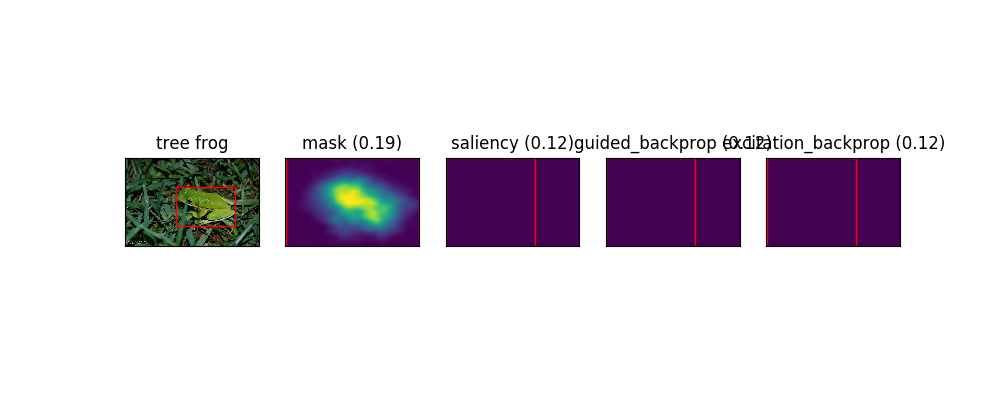

<IPython.core.display.Javascript object>


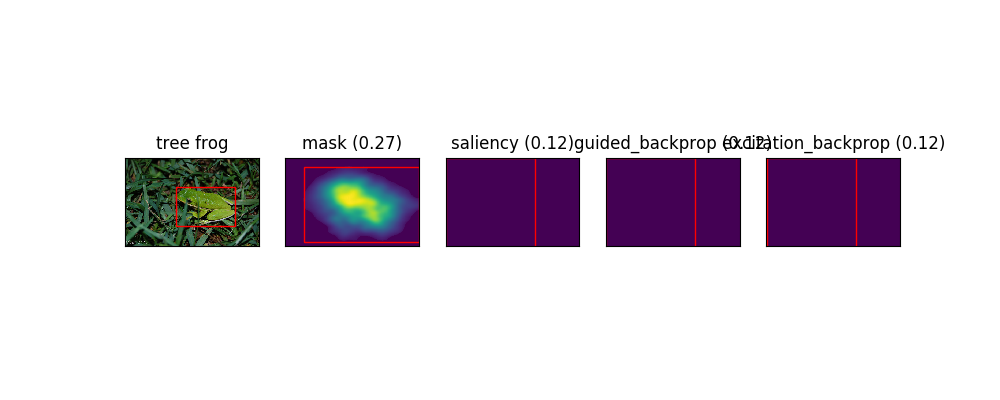

<IPython.core.display.Javascript object>


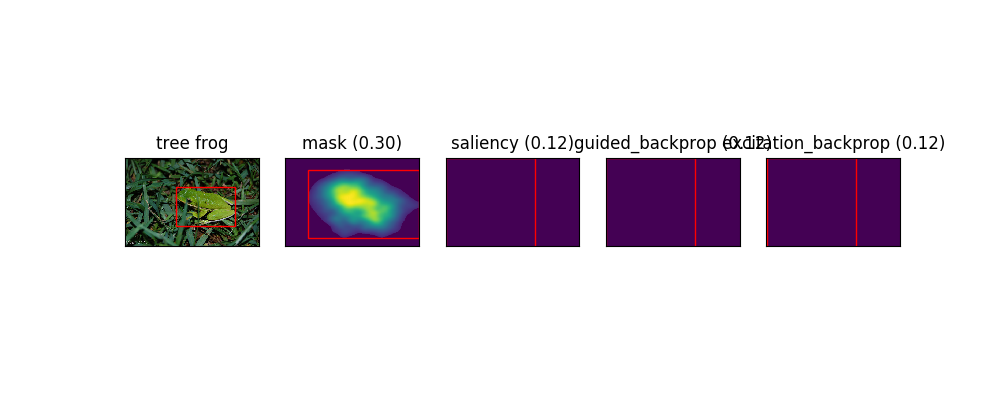

<IPython.core.display.Javascript object>


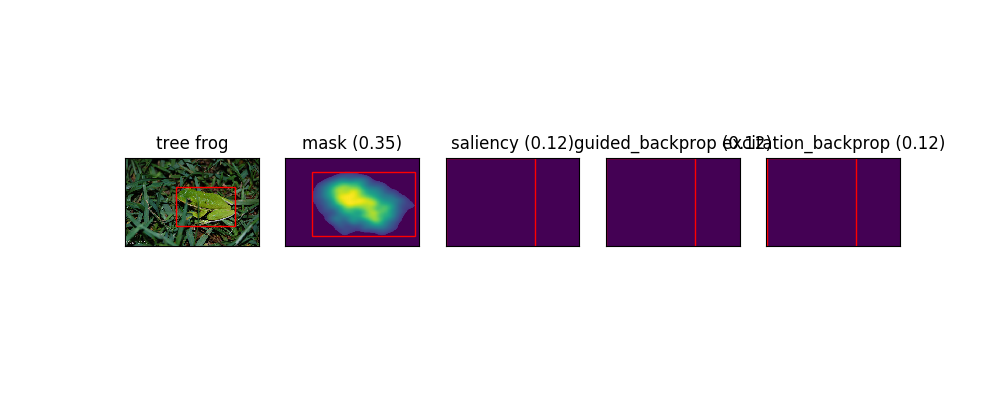

<IPython.core.display.Javascript object>


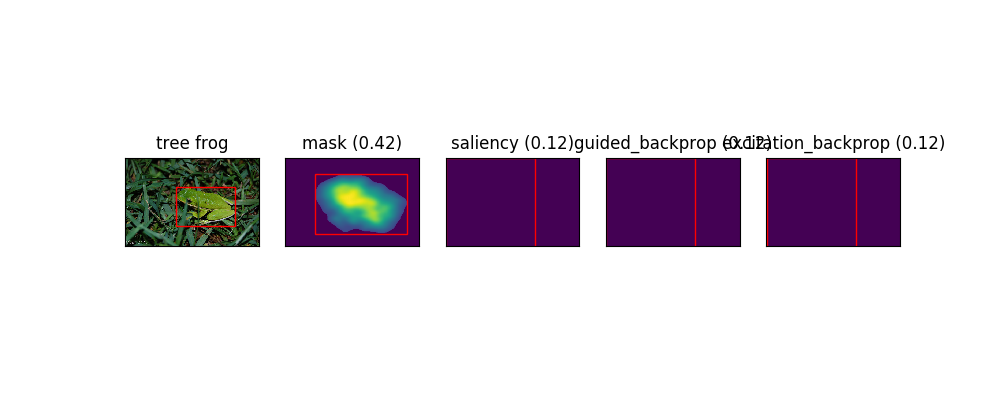

<IPython.core.display.Javascript object>


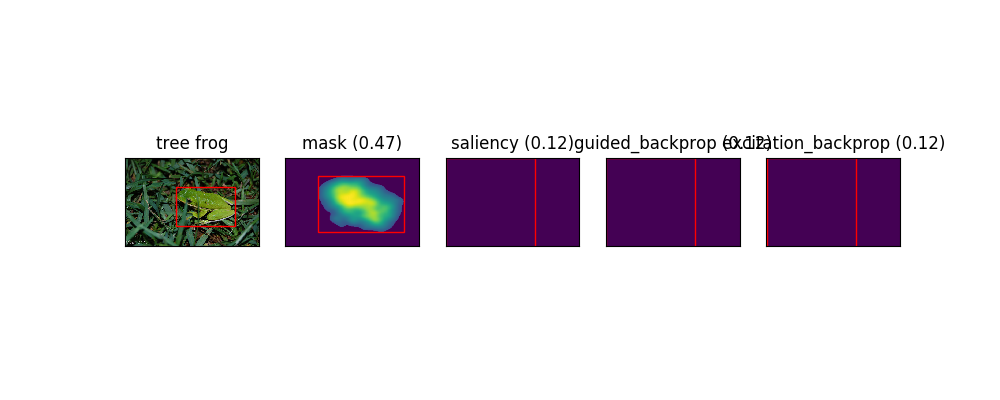

<IPython.core.display.Javascript object>


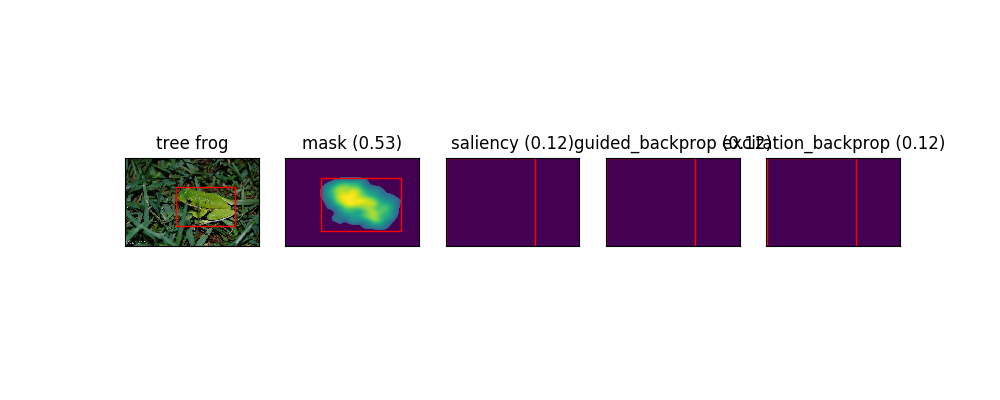

<IPython.core.display.Javascript object>


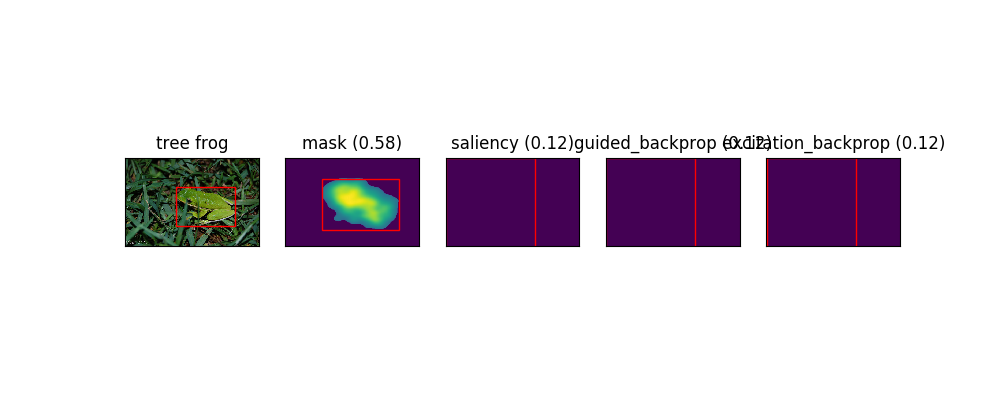

<IPython.core.display.Javascript object>


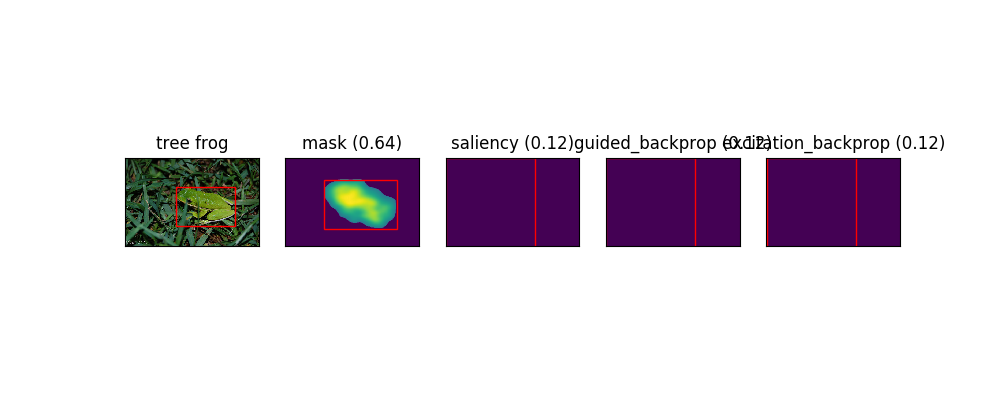

<IPython.core.display.Javascript object>


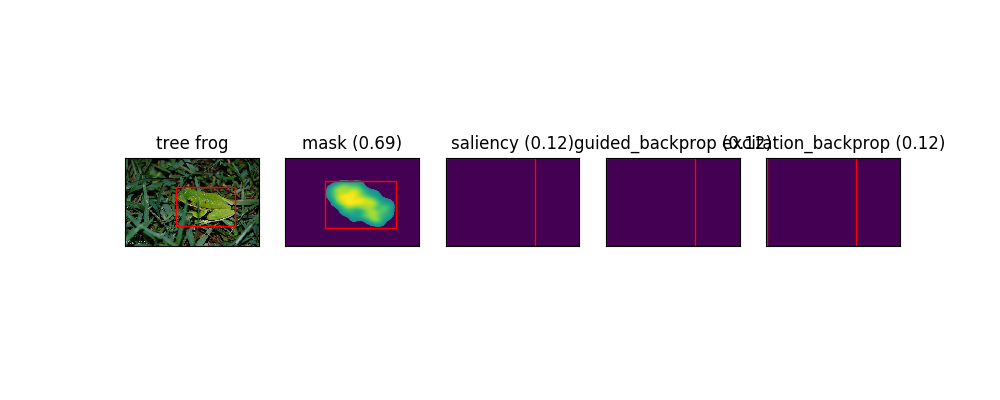

<IPython.core.display.Javascript object>


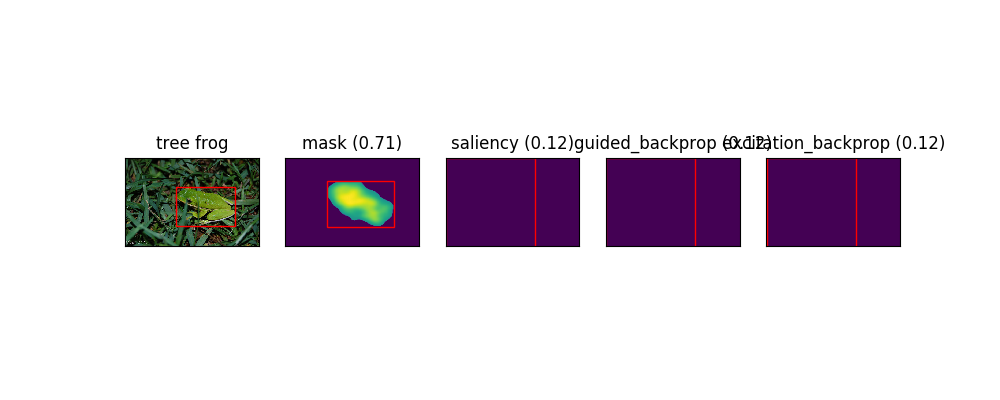

<IPython.core.display.Javascript object>


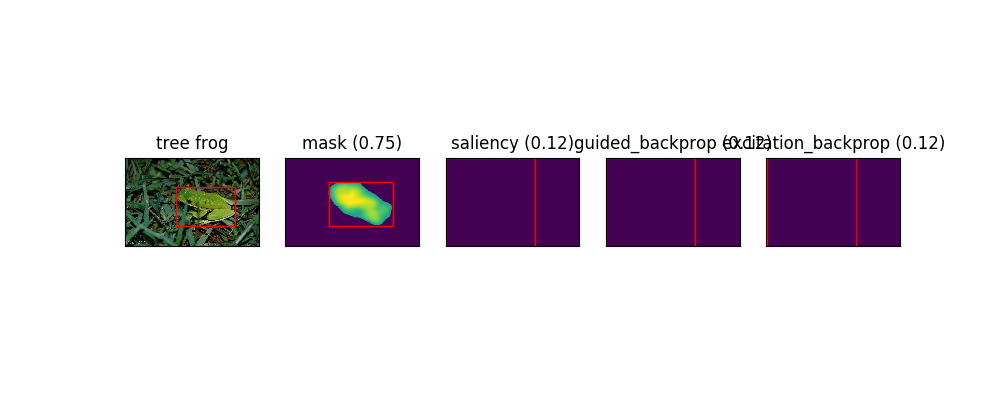

<IPython.core.display.Javascript object>


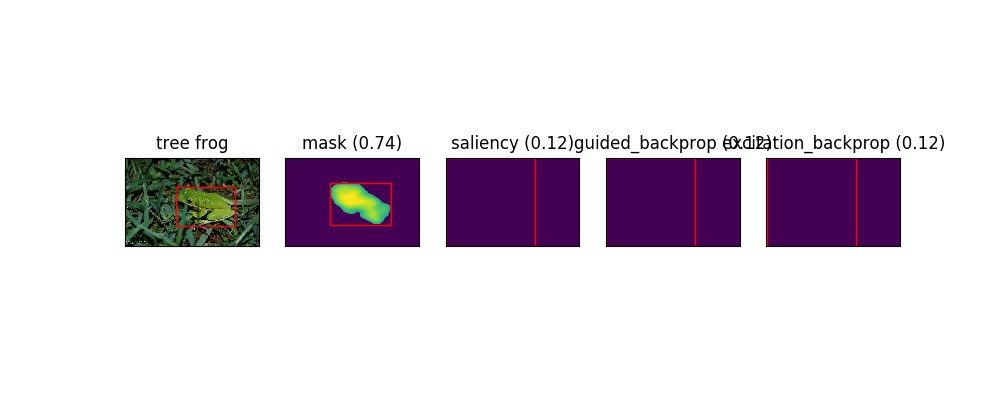

<IPython.core.display.Javascript object>


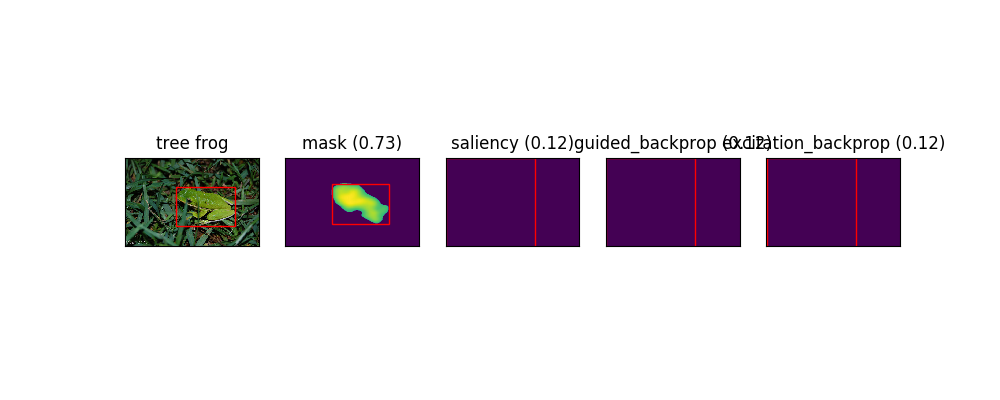

<IPython.core.display.Javascript object>


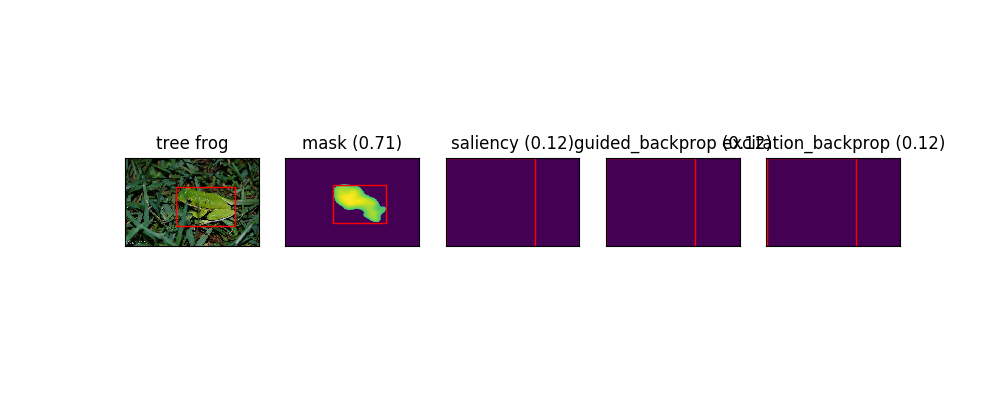

<IPython.core.display.Javascript object>


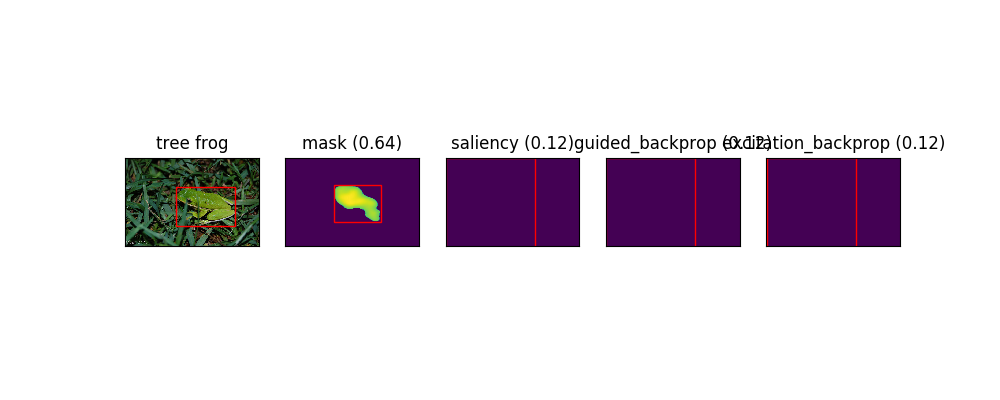

<IPython.core.display.Javascript object>


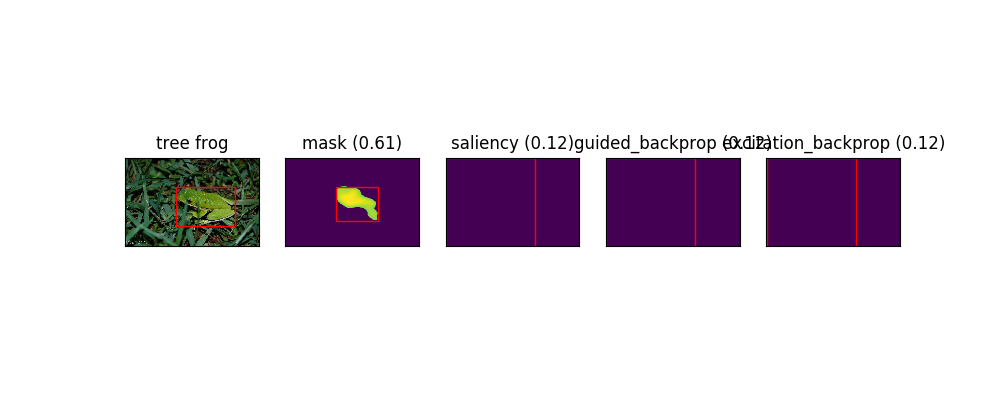

<IPython.core.display.Javascript object>


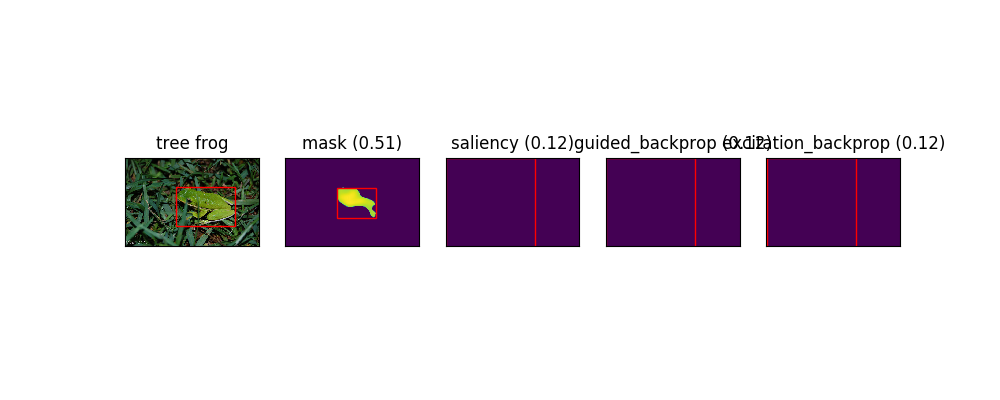

<IPython.core.display.Javascript object>


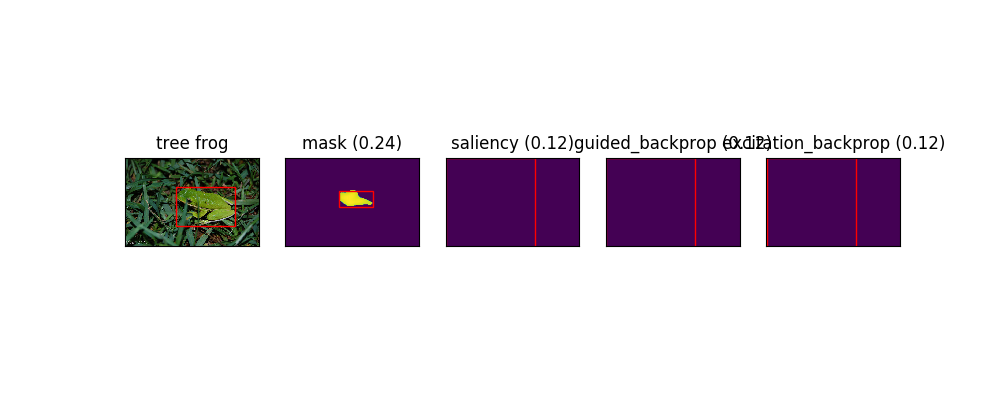

<IPython.core.display.Javascript object>


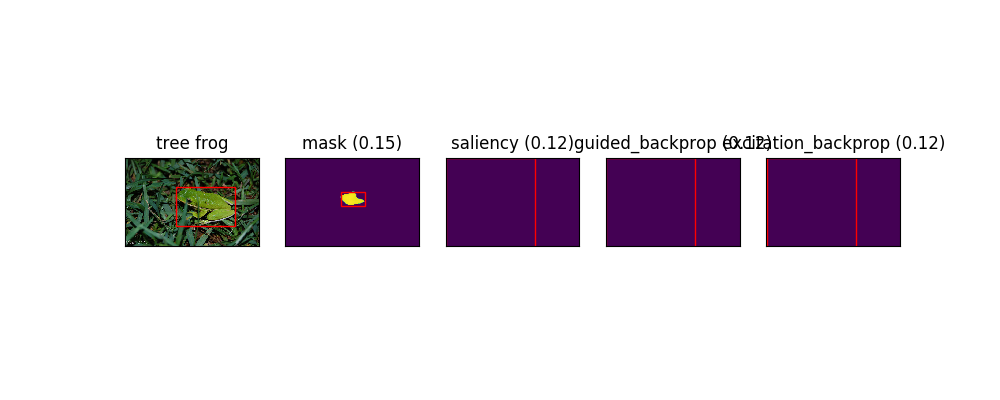

In [6]:
alphas = np.arange(0,1,0.05)
ind = 31
bb_method = 'min_max_diff'
for alpha in alphas:
    visualize_heatmaps(net, paths[ind], mask_paths[ind], ann_paths[ind], labels[ind], show_bbs = True, 
                       mask_alpha = alpha, bb_method = bb_method, mask_flip = True, thres_first = True, gpu = None,
                       synsets = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                       indexing = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/ascii_order_to_synset_order.txt'))

# Mean Alpha

In [8]:
ann_dir = '/data/ruthfong/ILSVRC2012/val'
ann_paths = np.sort([os.path.join(ann_dir, f) for f in os.listdir(ann_dir)])

bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_val_gt_pycaffe/excitation_backprop/mean_pool3_alpha_1.50_norm_-1.txt'
(err, _, _) = compute_localization_results(bb_file, ann_paths, synsets=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t'),
                             reverse_indexing=np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt', dtype=int))
print 'excitation_backprop (pool3)', err

excitation_backprop (pool3) 0.41904
